In [53]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [54]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [55]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [56]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [57]:
tf.keras.backend.clear_session()

In [58]:
subject = 'Rio Grande Do Norte - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [59]:
data = pd.read_csv('2003_mo_model_input_RN.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio Grande do Norte - IDH Longevidade,Rio Grande Do Norte - Consumo de Cimento (t),Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.793473,36.825,0.631207,0.689488,9944.060800,1.853436,1006.950610,8770.488958,26.531232,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,0.629167,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.793993,34.088,0.631578,0.689892,10034.559262,1.852423,1006.950925,8770.488958,26.531261,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,0.629592,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.794514,30.150,0.631948,0.690297,10120.152965,1.851832,1006.951108,8770.488958,26.531278,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,0.630017,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.795034,31.224,0.632319,0.690702,10199.169751,1.851769,1006.951128,8770.488958,26.531280,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,0.630443,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.795555,33.606,0.632689,0.691107,10272.393199,1.893568,1006.815853,8100.094916,26.560194,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,0.630868,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


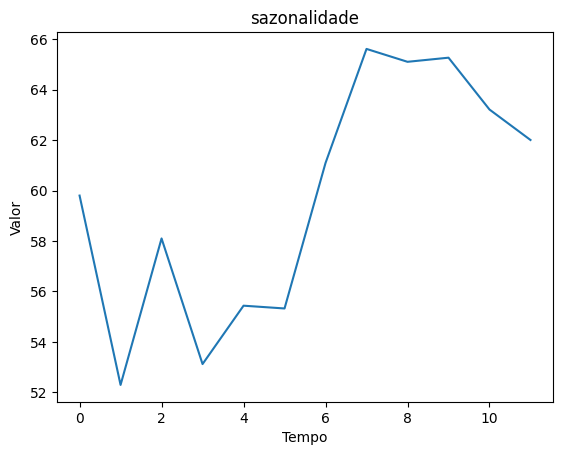

,sazonalidade
sazonalidade,
0,59.798725
1,52.289793
2,58.098576
3,53.116962
4,55.432047
5,55.321868
6,61.091975
7,65.614959
8,65.103883


In [60]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [61]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio Grande do Norte - IDH Longevidade,Rio Grande do Norte - IDH Renda,Rio Grande do Norte - IDH,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - PIB - Per Capita,Rio Grande do Norte - PIB - Preços de Mercado,Rio Grande do Norte - Desemprego,Rio Grande do Norte - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Rio Grande Do Norte - Consumo de Cimento (t)
0,2003-1,0.793473,0.631207,0.689488,9944.060800,1.853436,1006.950610,8770.488958,26.531232,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,9.097985,2.879532e+07,8.294170,0.629167,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,59.798725,36.825
1,2003-2,0.793993,0.631578,0.689892,10034.559262,1.852423,1006.950925,8770.488958,26.531261,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,9.101271,2.881033e+07,8.288224,0.629592,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,52.289793,34.088
2,2003-3,0.794514,0.631948,0.690297,10120.152965,1.851832,1006.951108,8770.488958,26.531278,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,9.104557,2.882535e+07,8.282278,0.630017,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,58.098576,30.150
3,2003-4,0.795034,0.632319,0.690702,10199.169751,1.851769,1006.951128,8770.488958,26.531280,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,9.107843,2.884036e+07,8.276332,0.630443,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,53.116962,31.224
4,2003-5,0.795555,0.632689,0.691107,10272.393199,1.893568,1006.815853,8100.094916,26.560194,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,9.111128,2.885538e+07,8.270387,0.630868,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,55.432047,33.606
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,33765.107382,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.432047,NaN
245,2023-6,NaN,NaN,NaN,33727.122646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.321868,NaN
246,2023-7,NaN,NaN,NaN,33669.488232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.091975,NaN
247,2023-8,NaN,NaN,NaN,33582.407753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.614959,NaN


In [62]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      38.146
1      30.350
2      33.791
3      30.891
4      30.724
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 249, dtype: float64

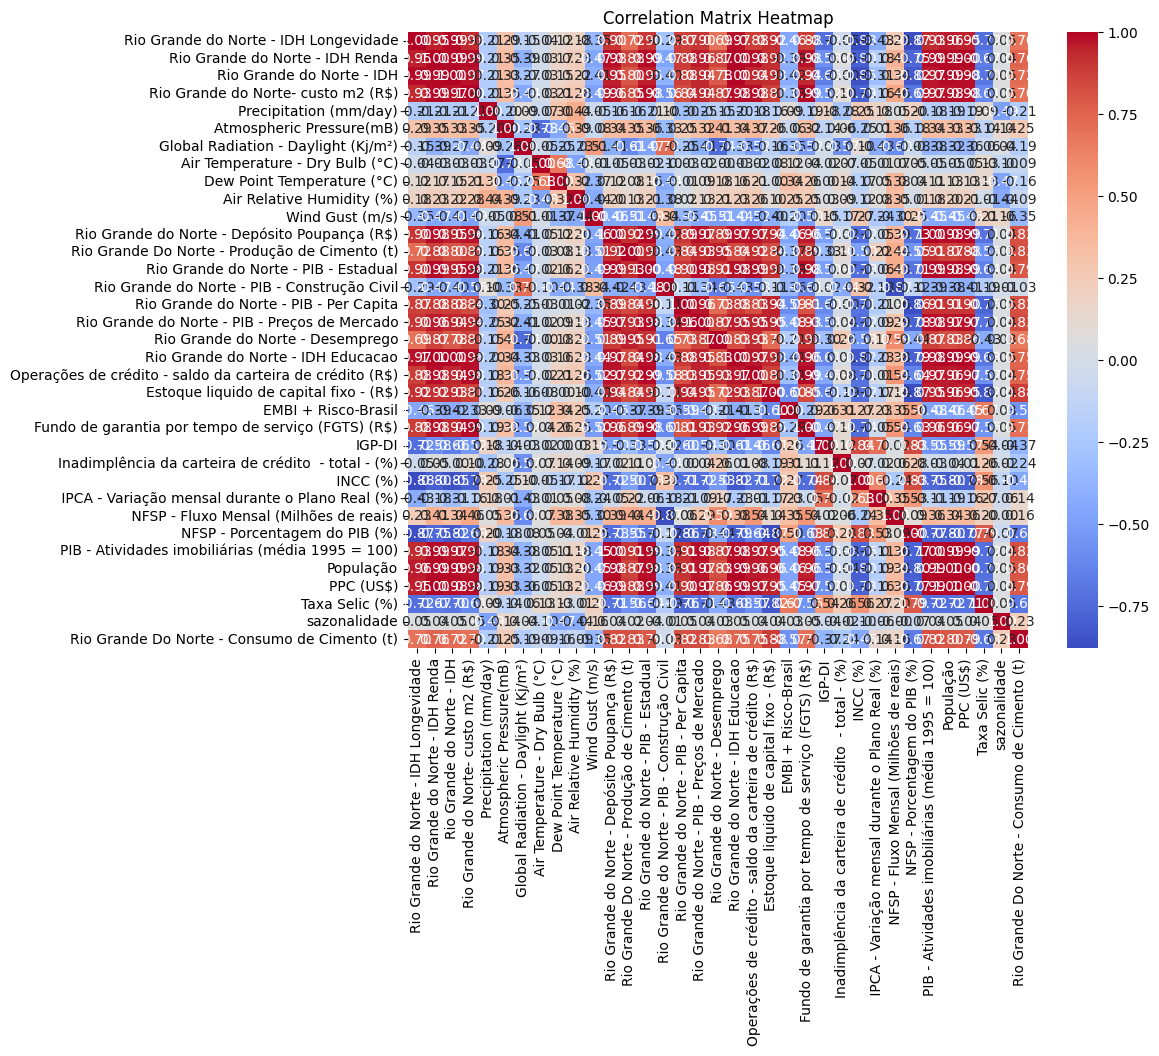

In [63]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [65]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Rio Grande do Norte - IDH Longevidade,1.083963e+09
1,Rio Grande do Norte - IDH Renda,3.729009e+08
2,Rio Grande do Norte - IDH,9.015972e+09
3,Rio Grande do Norte- custo m2 (R$),2.192325e+06
4,Precipitation (mm/day),8.599563e+01
5,Atmospheric Pressure(mB),4.329897e+07
6,Global Radiation - Daylight (Kj/m²),1.314764e+02
7,Air Temperature - Dry Bulb (°C),1.308940e+07
8,Dew Point Temperature (°C),9.546365e+06
9,Air Relative Humidity (%),5.192116e+06


In [66]:
# data = data.drop(['Global Radiation - Daylight (Kj/m²)',
#                  'sazonalidade'], axis=1)
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 10


,Rio Grande do Norte- custo m2 (R$),Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,9944.060800,1.853436,8770.488958,21.591412,74.870205,5.667138,1.843384e+06,27.698760,3.164847e+07,1.998664e+06,8.294170,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,59.798725
1,10034.559262,1.852423,8770.488958,21.591907,74.872429,5.663569,1.855573e+06,27.407645,3.168897e+07,2.001107e+06,8.288224,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,52.289793
2,10120.152965,1.851832,8770.488958,21.592195,74.873726,5.661487,1.867763e+06,27.377422,3.172947e+07,2.003550e+06,8.282278,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,58.098576
3,10199.169751,1.851769,8770.488958,21.592226,74.873865,5.661264,1.879953e+06,27.542280,3.176997e+07,2.005994e+06,8.276332,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,53.116962
4,10272.393199,1.893568,8100.094916,21.749605,75.499649,5.413625,1.892142e+06,27.944900,3.181046e+07,2.008437e+06,8.270387,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,55.432047
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,22667.876931,1.112544,1585.638054,21.706546,78.033772,4.521432,3.979186e+06,80.136073,3.753144e+07,1.955482e+06,13.086992,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,65.614959
176,22768.661519,1.158703,1580.761718,21.812749,77.284393,4.534592,3.994911e+06,79.367321,3.752295e+07,1.955479e+06,13.080150,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,65.103883
177,22873.012843,1.193569,1576.901127,22.042374,76.714940,4.412130,4.010636e+06,78.709496,3.751445e+07,1.955477e+06,13.073309,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,65.267355
178,22977.830604,1.359099,1562.429272,22.250285,76.583684,4.158167,4.026361e+06,78.131255,3.750595e+07,1.955475e+06,13.066467,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174,63.211432


In [67]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.347275,-0.044027,-0.392013,-0.405239,0.900843,-1.701036,-1.126279,-1.675640,-0.939011,-0.811236,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040
1,0.345202,-0.044027,-0.391120,-0.404212,0.897172,-1.683809,-1.135235,-1.655248,-0.886466,-0.813666,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580
2,0.343993,-0.044027,-0.390598,-0.403612,0.895031,-1.666581,-1.136165,-1.634857,-0.833921,-0.816096,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368
3,0.343864,-0.044027,-0.390542,-0.403548,0.894802,-1.649353,-1.131093,-1.614465,-0.781376,-0.818526,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384
4,0.429369,-0.121944,-0.106082,-0.114513,0.640065,-1.632125,-1.118707,-1.594073,-0.728831,-0.820957,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-1.168317,-0.879092,-0.183910,1.055941,-0.277698,1.317502,0.486880,1.286547,-1.867690,1.147646,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.421090,-1.472938
176,-1.073892,-0.879659,0.008052,0.709820,-0.264160,1.339727,0.463230,1.282269,-1.867743,1.144850,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.432650,-0.879688
177,-1.002570,-0.880108,0.423096,0.446803,-0.390132,1.361951,0.442993,1.277991,-1.867795,1.142053,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.443731,-0.427616
178,-0.663956,-0.881790,0.798892,0.386179,-0.651373,1.384175,0.425205,1.273713,-1.867847,1.139257,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.454507,-0.000772


In [68]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
0,0.347275,-0.044027,-0.392013,-0.405239,0.900843,-1.701036,-1.126279,-1.675640,-0.939011,-0.811236,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040
1,0.345202,-0.044027,-0.391120,-0.404212,0.897172,-1.683809,-1.135235,-1.655248,-0.886466,-0.813666,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580
2,0.343993,-0.044027,-0.390598,-0.403612,0.895031,-1.666581,-1.136165,-1.634857,-0.833921,-0.816096,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368
3,0.343864,-0.044027,-0.390542,-0.403548,0.894802,-1.649353,-1.131093,-1.614465,-0.781376,-0.818526,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384
4,0.429369,-0.121944,-0.106082,-0.114513,0.640065,-1.632125,-1.118707,-1.594073,-0.728831,-0.820957,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,-0.895787,-0.868752,-0.275764,0.172424,-0.188852,1.067737,0.827055,1.296571,-1.765982,1.223628,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.261902,0.499090
164,-0.856822,-0.866387,-0.000380,-0.090568,-0.134134,1.086576,0.802726,1.300555,-1.786251,1.212346,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.276272,0.323875
165,-0.668571,-0.865819,0.360829,-0.206454,-0.152926,1.105415,0.781969,1.304540,-1.806519,1.201065,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.290351,0.198030
166,-0.483098,-0.866883,0.827836,-0.137863,-0.279007,1.124254,0.765539,1.308525,-1.826787,1.189783,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.304501,0.502803


In [69]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      38.146
1      30.350
2      33.791
3      30.891
4      30.724
        ...  
163    48.520
164    41.365
165    43.813
166    43.816
167    38.245
Name: Rio Grande Do Norte - Consumo de Cimento (t), Length: 168, dtype: float64

In [70]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [71]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 22)

In [72]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Precipitation (mm/day),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio Grande do Norte - Depósito Poupança (R$),Rio Grande Do Norte - Produção de Cimento (t),Rio Grande do Norte - PIB - Estadual,Rio Grande do Norte - PIB - Construção Civil,Rio Grande do Norte - Desemprego,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%)
132,0.275028,-0.861989,0.615706,-0.580219,-0.741717,1.299535,1.465443,1.012160,-0.377404,1.214801,0.992500,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.878252,-0.590376
133,0.272126,-0.868397,0.980776,-0.016082,-0.935877,1.286225,1.453564,1.025325,-0.429646,1.223335,1.013803,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.887574,-0.476859
134,1.040927,-0.877993,1.089355,0.617337,-1.007457,1.272915,1.450441,1.038489,-0.481889,1.231870,1.036490,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.896990,-0.089952
135,0.918255,-0.888131,0.775479,1.076980,-1.001065,1.259605,1.446041,1.051654,-0.534131,1.240405,1.059637,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.906245,-0.814200
136,1.012299,-0.892530,0.164120,1.335235,-0.867192,1.246295,1.440508,1.064818,-0.586373,1.248939,1.080606,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.915208,-0.917944
137,1.195586,-0.890801,-0.312332,1.307783,-0.717211,1.232985,1.433746,1.077982,-0.638616,1.257474,1.101264,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.924126,-0.708692
138,0.267376,-0.883581,-0.672623,0.949224,-0.522401,1.219674,1.425836,1.091147,-0.690858,1.266009,1.123860,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.932114,-0.496126
139,0.155931,-0.874739,-0.772811,0.451760,-0.431622,1.206364,1.416841,1.104311,-0.743100,1.274543,1.150086,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.939863,-0.251065
140,0.049703,-0.870604,-0.557360,0.297702,-0.415142,1.193054,1.406794,1.117475,-0.795343,1.283078,1.179474,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.947944,-0.593206
141,-0.405245,-0.865607,-0.438401,-0.168325,-0.373780,1.179744,1.395804,1.130640,-0.847585,1.291613,1.214576,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.956229,-0.100794


In [73]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 22)

In [74]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(144, activation='tanh',
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.LSTM(72, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [75]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [76]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [77]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            print(f"\n\Results: {i} ___________________________________________")
            display(df_results.T)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [78]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[2279683193, 2772531586, 3560001720, 586098901, 3595449323, 3319367418, 332761947, 1199969859, 857049837, 4289776518]


Step: 0 ___________________________________________
val_loss: 97.97303009033203
winner_seed: 2279683193


Step: 1 ___________________________________________
val_loss: 39.627384185791016
winner_seed: 2772531586


Step: 2 ___________________________________________
val_loss: 73.65248107910156


Step: 3 ___________________________________________
val_loss: 60.59391403198242


Step: 4 ___________________________________________
val_loss: 94.36302185058594


Step: 5 ___________________________________________
val_loss: 101.30872344970703


Step: 6 ___________________________________________
val_loss: 64.13542938232422


Step: 7 ___________________________________________
val_loss: 137.9779510498047


Step: 8 ___________________________________________
val_loss: 30.86391258239746
winner_seed: 857049837


Step: 9 ___________________________________________
val_loss: 56.9041

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,39.243294,37.989479,36.045547,34.533554,32.551567,31.306532,30.839729,32.92289,35.534821,34.372467,33.013496,32.509354
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,6.837708,0.71352,0.008549,3.896446,11.919434,6.577467,20.74527,21.38311,16.976181,25.099533,21.008503,17.281647


[1677729973, 612570151, 1735767910, 2027093858, 1778987037, 3170221628, 3214121903, 1337788630, 4247679795, 187295816]


Step: 0 ___________________________________________
val_loss: 50.24369430541992
winner_seed: 1677729973


Step: 1 ___________________________________________
val_loss: 101.6903076171875


Step: 2 ___________________________________________
val_loss: 65.30827331542969


Step: 3 ___________________________________________
val_loss: 70.21268463134766


Step: 4 ___________________________________________
val_loss: 42.85459518432617
winner_seed: 1778987037


Step: 5 ___________________________________________
val_loss: 56.91410446166992


Step: 6 ___________________________________________
val_loss: 63.034324645996094


Step: 7 ___________________________________________
val_loss: 74.58919525146484


Step: 8 ___________________________________________
val_loss: 58.14810562133789


Step: 9 ___________________________________________
val_loss: 101.3310546875
1/1 [==========

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,44.64209,44.487953,44.231487,43.887531,43.385296,43.237446,43.647968,46.932564,49.276546,50.213322,48.24062,46.188576
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,1.438911,5.784954,8.194489,5.457531,1.085705,5.353447,7.937031,7.373436,3.234455,9.258678,5.78138,3.602425


[330748382, 604118527, 2246344010, 1223677848, 2876495871, 4122375598, 337563404, 3395958461, 2926466568, 3876311530]


Step: 0 ___________________________________________
val_loss: 67.50189208984375
winner_seed: 330748382


Step: 1 ___________________________________________
val_loss: 82.16011810302734


Step: 2 ___________________________________________
val_loss: 58.033348083496094
winner_seed: 2246344010


Step: 3 ___________________________________________
val_loss: 65.29743957519531


Step: 4 ___________________________________________
val_loss: 60.01383590698242


Step: 5 ___________________________________________
val_loss: 81.39318084716797


Step: 6 ___________________________________________
val_loss: 92.80208587646484


Step: 7 ___________________________________________
val_loss: 82.11051177978516


Step: 8 ___________________________________________
val_loss: 47.10402297973633
winner_seed: 2926466568


Step: 9 ___________________________________________
val_loss: 47.73099

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,42.167603,42.169231,42.264446,42.702454,43.255051,44.5187,48.737057,57.642471,61.641006,61.646137,56.469025,49.507805
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,3.913399,3.466232,6.227448,4.272453,1.21595,6.634701,2.847942,3.336472,9.130005,2.174137,2.447025,0.283195


[4220052692, 570977273, 496896009, 1994480262, 4063598910, 3810183269, 2832633365, 2202635006, 72445793, 2646223194]


Step: 0 ___________________________________________
val_loss: 100.70445251464844
winner_seed: 4220052692


Step: 1 ___________________________________________
val_loss: 58.100196838378906
winner_seed: 570977273


Step: 2 ___________________________________________
val_loss: 76.48375701904297


Step: 3 ___________________________________________
val_loss: 93.0472412109375


Step: 4 ___________________________________________
val_loss: 51.6163444519043
winner_seed: 4063598910


Step: 5 ___________________________________________
val_loss: 51.09495162963867
winner_seed: 3810183269


Step: 6 ___________________________________________
val_loss: 47.30205535888672
winner_seed: 2832633365


Step: 7 ___________________________________________
val_loss: 30.34590721130371
winner_seed: 2202635006


Step: 8 ___________________________________________
val_loss: 103.11046600341797



,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,43.683598,43.048599,42.353592,41.752048,41.38147,41.915787,43.177071,45.612946,49.07333,49.819473,47.959671,46.273598
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,2.397404,4.3456,6.316593,3.322048,3.089531,4.031788,8.407928,8.693054,3.437672,9.652527,6.062328,3.517403


[297031166, 1883623091, 659562436, 1073986055, 2435469495, 1452427288, 3537894275, 1286030383, 4079691860, 2498681826]


Step: 0 ___________________________________________
val_loss: 85.30408477783203
winner_seed: 297031166


Step: 1 ___________________________________________
val_loss: 74.2005844116211
winner_seed: 1883623091


Step: 2 ___________________________________________
val_loss: 28.515451431274414
winner_seed: 659562436


Step: 3 ___________________________________________
val_loss: 70.60383605957031


Step: 4 ___________________________________________
val_loss: 96.43268585205078


Step: 5 ___________________________________________
val_loss: 43.902610778808594


Step: 6 ___________________________________________
val_loss: 79.09300231933594


Step: 7 ___________________________________________
val_loss: 86.04132843017578


Step: 8 ___________________________________________
val_loss: 61.74436569213867


Step: 9 ___________________________________________
val_loss: 66.80438

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,41.323708,41.407833,41.580235,41.8424,42.288731,43.096252,43.948364,51.82946,57.437977,58.836716,56.840813,49.055851
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,4.757294,2.704834,5.543236,3.412399,2.18227,5.212254,7.636635,2.47654,4.926975,0.635284,2.818813,0.735149


[889952987, 3024512184, 1524476978, 2133108654, 556339983, 1868759911, 1341900965, 2606907257, 647526754, 3491832956]


Step: 0 ___________________________________________
val_loss: 70.36944580078125
winner_seed: 889952987


Step: 1 ___________________________________________
val_loss: 28.895273208618164
winner_seed: 3024512184


Step: 2 ___________________________________________
val_loss: 113.1421890258789


Step: 3 ___________________________________________
val_loss: 50.94979476928711


Step: 4 ___________________________________________
val_loss: 68.20271301269531


Step: 5 ___________________________________________
val_loss: 104.02532196044922


Step: 6 ___________________________________________
val_loss: 61.382171630859375


Step: 7 ___________________________________________
val_loss: 67.35740661621094


Step: 8 ___________________________________________
val_loss: 34.49384307861328


Step: 9 ___________________________________________
val_loss: 105.52796173095703
1/1 [======

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,42.399639,42.486267,42.441776,42.153336,41.702606,42.000088,43.45137,46.897591,49.985428,48.299271,45.008392,43.524845
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,3.681362,3.783268,6.404778,3.723335,2.768394,4.116089,8.133629,7.408409,2.525574,11.172729,9.013607,6.266155


[2546140497, 259842273, 1747940747, 2548796781, 2904693266, 2638941466, 3734212423, 1626942615, 386684068, 2542691269]


Step: 0 ___________________________________________
val_loss: 83.2577896118164
winner_seed: 2546140497


Step: 1 ___________________________________________
val_loss: 71.03069305419922
winner_seed: 259842273


Step: 2 ___________________________________________
val_loss: 109.79191589355469


Step: 3 ___________________________________________
val_loss: 31.149911880493164
winner_seed: 2548796781


Step: 4 ___________________________________________
val_loss: 90.8807601928711


Step: 5 ___________________________________________
val_loss: 46.06165313720703


Step: 6 ___________________________________________
val_loss: 57.364871978759766


Step: 7 ___________________________________________
val_loss: 89.96512603759766


Step: 8 ___________________________________________
val_loss: 65.86211395263672


Step: 9 ___________________________________________
val_loss: 97.3227

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,38.870369,39.306717,39.575249,39.861588,40.174347,41.346844,45.77433,51.740791,55.506447,56.673645,55.445107,49.638161
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,7.210632,0.603718,3.53825,1.431587,4.296654,3.462845,5.810669,2.565208,2.995445,2.798355,1.423107,0.15284


[2405093581, 2873701032, 2377844562, 497470348, 2362234799, 1648709664, 3895771903, 1952401745, 40728884, 333234209]


Step: 0 ___________________________________________
val_loss: 28.676555633544922
winner_seed: 2405093581


Step: 1 ___________________________________________
val_loss: 58.24677276611328


Step: 2 ___________________________________________
val_loss: 65.80216217041016


Step: 3 ___________________________________________
val_loss: 73.15159606933594


Step: 4 ___________________________________________
val_loss: 92.16310119628906


Step: 5 ___________________________________________
val_loss: 34.93111038208008


Step: 6 ___________________________________________
val_loss: 30.558706283569336


Step: 7 ___________________________________________
val_loss: 30.755170822143555


Step: 8 ___________________________________________
val_loss: 128.2729949951172


Step: 9 ___________________________________________
val_loss: 60.002811431884766
1/1 [==============================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,35.002075,33.569576,32.427387,31.614536,30.876305,30.986202,33.146091,39.536274,43.11742,43.745358,40.947666,35.746788
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,11.078926,5.133423,3.609612,6.815464,13.594696,6.897797,18.438908,14.769726,9.393581,15.726643,13.074333,14.044212


[3210494703, 2498925878, 312594281, 1820758468, 3097906870, 3996466465, 2540532222, 2161494398, 2840683229, 630634871]


Step: 0 ___________________________________________
val_loss: 35.80778503417969
winner_seed: 3210494703


Step: 1 ___________________________________________
val_loss: 42.8089485168457


Step: 2 ___________________________________________
val_loss: 60.93810272216797


Step: 3 ___________________________________________
val_loss: 81.71338653564453


Step: 4 ___________________________________________
val_loss: 82.85030364990234


Step: 5 ___________________________________________
val_loss: 63.71431350708008


Step: 6 ___________________________________________
val_loss: 82.10093688964844


Step: 7 ___________________________________________
val_loss: 100.79542541503906


Step: 8 ___________________________________________
val_loss: 85.27882385253906


Step: 9 ___________________________________________
val_loss: 59.47749710083008
1/1 [==============================] 

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,42.960171,43.583317,43.674282,43.631001,43.274338,42.74609,43.143929,53.803978,58.359539,53.728523,47.688808,45.935719
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,3.120831,4.880318,7.637283,5.201,1.196663,4.862091,8.441071,0.502022,5.848537,5.743477,6.333191,3.855282


[2731239294, 2075623183, 847056652, 829052092, 3846435120, 584018377, 3024547286, 3368269650, 1501790524, 2026758825]


Step: 0 ___________________________________________
val_loss: 39.057987213134766
winner_seed: 2731239294


Step: 1 ___________________________________________
val_loss: 76.57621765136719


Step: 2 ___________________________________________
val_loss: 123.97682189941406


Step: 3 ___________________________________________
val_loss: 215.4178009033203


Step: 4 ___________________________________________
val_loss: 124.72249603271484


Step: 5 ___________________________________________
val_loss: 107.40540313720703


Step: 6 ___________________________________________
val_loss: 65.93778228759766


Step: 7 ___________________________________________
val_loss: 67.6766128540039


Step: 8 ___________________________________________
val_loss: 46.82033157348633


Step: 9 ___________________________________________
val_loss: 59.85601806640625
1/1 [==============================

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,43.010651,43.116577,43.16169,43.464798,44.370255,45.362846,46.1922,54.849243,60.928673,59.632286,51.488846,46.721771
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,3.070351,4.413578,7.124691,5.034798,0.100746,7.478848,5.392799,0.543243,8.417671,0.160286,2.533154,3.069229


'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,41.330322,41.116554,40.77557,40.544323,40.325996,40.65168,42.205811,48.176823,52.086113,51.696716,48.310242,44.510246
Target,46.081,38.703,36.037,38.43,44.471,37.884,51.585,54.306,52.511,59.472,54.022,49.791
Error,4.750678,2.413554,4.73857,2.114323,4.145004,2.76768,9.379189,6.129177,0.424887,7.775284,5.711758,5.280754


In [79]:
display(mae)
display(mape)

44.310867

0.09696085558356377